# Devices in `vipdopt`

The `Device` class is how optical devices are represented in `vipdopt`. A `Device` object contains a 3D voxel-grid design region, with each voxel having its own refractive index, along with a number of helpful methods for interacting with the rest of the code library.


For later cells to work, please run the following block first.

TODO:
* Filters
* initialization parameters
* binarization
* exporting design
* importing into simulation

In [1]:
# imports
from pathlib import Path
import sys  

import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(threshold=100)

# Get vipdopt directory path from Notebook
parent_dir = str(Path().resolve().parents[1])

# Add to sys.path
sys.path.insert(0, parent_dir)

# Imports from vipdopt
from vipdopt.optimization import Device, Sigmoid, Scale
from vipdopt.simulation import LumericalFDTD, LumericalSimulation, Source

## Creating a `Device`

A `Device` requires a number of parameters to be created:
* The size of the 3D-grid in voxels, given as a 3-tuple of integers
* A Minimum and maximum permittivity
* The coordinates of device in 3D space
    * This utilizes a `Coordinates`, which is just a dictionary with 'x', 'y', and 'z'


Text(0.5, 1.0, 'Initial Design Variable')

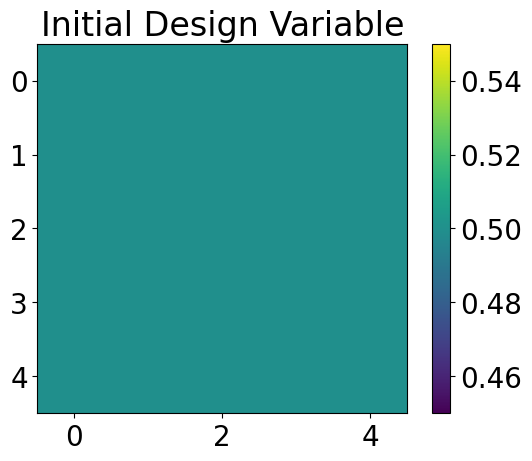

In [2]:
device_size = (5, 5, 5)  # use a 5x5x5 grid for the design region
permittivity_bounds = (0, 1)

# Center the device at the origin with a voxel size of 1
coords = {
    'x': np.linspace(-2.5, 2.5, 5),
    'y': np.linspace(-2.5, 2.5, 5),
    'z': np.linspace(-2.5, 2.5, 5),
}

dev = Device(
    device_size,
    permittivity_bounds,
    coords
)

# By default the device will have density 0.5 everywhere
# Plot the design variable (the slice at z=0)
im = plt.imshow(dev.get_design_variable().real[..., 0])
plt.colorbar(im)
plt.title('Initial Design Variable')

## Optional Parameters
There are a number of optional parameters when creating a `Device`:
* The name of the device (defaults to "device") 
* A list of `Filters`
* Initialization parameters that are further described in the following section

### Initialization Parameters

When creating a new device, there are a number of settings that can be tweaked to
change the intital permittivity values it will be populated with

#### Initial Density

The initial density of the device is the parameter we are optimizing (frequently 
referred to as the "design variable"). It is then passed through `Filters` (possibly 
non-linearly) and then scaled to the permittivity contraints.

The `init_density` can be specified, or it defaults to 0.5. If `randomize` is `False`,
the entire design varibale will be set uniformly to the initial density.

#### Randomization

If `randomize` is set to `True`, then the values will be drawn from a normal
distribution centered at `init_density`, with scale 0.27.

A random seed can be specified by providing an integer. By default, the random seed is 
`None` which effectivley makes the seed random as well.

#### Symmetry

If `symmetric` is set to `True` the design variable will be symmetric over the line $y=x$.

### Miscellaneous Parameters

Additional paramerters can be passed into the `Device` using `kwargs`. These values won't
be used for any internal functionality in the `Device` but can be accessed as attributes
if desired.


Text(0.5, 1.0, 'Randomized Design Variable')

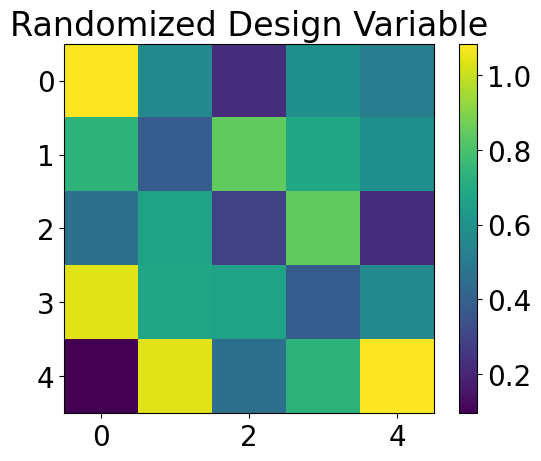

In [3]:
# Make the device randomized and symmetric this time
dev = Device(
    device_size,
    permittivity_bounds,
    coords,
    randomize=True,
    symmetric=True
)

# Plot the design variable (the slice at z=0)
im = plt.imshow(dev.get_design_variable().real[..., 0])  # Plot first layer 
plt.colorbar(im)
plt.title('Randomized Design Variable')

## `Filter`

The `Filter` class is used to apply modifications to the design variable before
converting to permittivity values. If you're familiar with machine learning,
`Filter`s are analagous to activation functions.

A `Filter` is essentially three functions bundled together:
* `forward`: passes an array through the `Filter`'s function
* `fabricate`: similar to `forward` but binarizes array values for fabrication
* `chain_rule`: the gradient of the `forward` function

There are two `Filter`s included in `vipdopt`:
* `Sigmoid` which applies a sigmoidal projection to push values to the 0/1 extremes.
* `Scale` which scales the input to a specified range

If a `Device` is created and there are no filters provided, or the last filter is not a `Scale` filter, a `Scale` filter will be appended to the end of the list with the permittivity constraints.

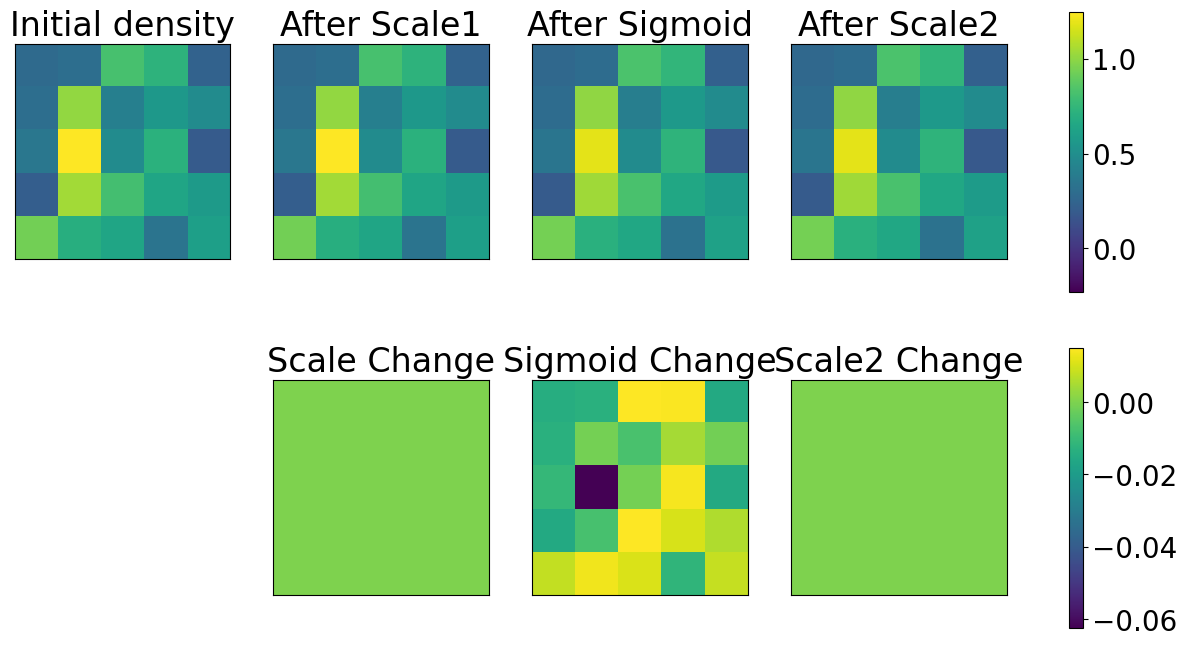

In [4]:
sig_fil = Sigmoid(0.5, 1)
scale_fil = Scale((0, 1))

dev = Device(
    device_size,
    permittivity_bounds,
    coords,
    randomize=True,
    init_seed=5,
    filters=[scale_fil, sig_fil]
)
dev.update_density()

# Plot the initial density and after applying each filter
gridspec = {'width_ratios': [1, 1, 1, 1]}
fig, axes = plt.subplots(2, 4, sharey=True, figsize=(16, 8), gridspec_kw=gridspec)
fig.delaxes(axes[1, 0])

min_val = dev.w.min().real
max_val = dev.w.max().real
for i in range(4):
    im = axes[0, i].imshow(dev.w[..., 0, i].real, vmin=min_val, vmax=max_val)
    # axes[0, i].set_xlabel('x')
    # axes[0, i].set_aspect('equal')

axes[0, 0].set_title('Initial density')
# axes[0, 0].set_ylabel('y')
axes[0, 1].set_title('After Scale1')
axes[0, 2].set_title('After Sigmoid')
axes[0, 3].set_title('After Scale2')
fig.colorbar(im, ax=axes[0, :])

differences = np.diff(dev.w[..., 0, :]).real
for i in range(1, 4):
    im = axes[1, i].imshow(differences[..., i - 1], vmin=differences.min(), vmax=differences.max())
    # axes[0, i].set_xlabel('x')

# axes[1, 1].set_ylabel('y')

fig.colorbar(im, ax=axes[1, :])
axes[1, 1].set_title('Scale Change')
axes[1, 2].set_title('Sigmoid Change')
axes[1, 3].set_title('Scale2 Change')

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])


# axs[0, 0].plot(dev.get_design_variable().real[..., 0])
# axs[0]
# plt.colorbar(im)
# plt.title('Randomized Design Variable')


## Working with Simulations

`Device`s can be imported into `LumericalSimulations`. To do this, a `LumericalSimulation`
**must** have an `Import` object to store the refractive index. Using `Device.impurt_cur_index`,
the relevant values will be saved into the `Import` object until the simulation is loaded
into Lumerical. For more details, see [the notebook on simulations](simulation.ipynb)

The index may need to be reinterpolated to match the size of the voxel grid in Lumerical.

In [5]:
# Set up simulation and get the Import object
sim = LumericalSimulation('simulation_example.json').with_enabled([Source('forward_src_x', 'gaussian')])
import_obj = sim.objects['design_import']

dev = Device(
    device_size,
    permittivity_bounds,
    coords,
    randomize=True,
    init_seed=0,
    filters=[Sigmoid(0.05, 0.5)],
)

# Store refractive index data in `import_obj`
_ = dev.import_cur_index(import_obj, reinterpolation_factor=1)

fdtd = LumericalFDTD()
fdtd.connect(hide=False)
fdtd.load_simulation(sim)  # This automatically imports the data stored in `import_obj`

C:\Users\tytym\Documents\Schmidt Academy\SonyBayerFilter\vipdopt\optimization\device.py:274: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.real(permittivity))


## Exporting a `Device`

TODO: GDS and STL exports, and save device to file